In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=1cbdcd40ad722c59aaf267d1f84ed7b72a9a64ce30a412145a4fd813fb7354da
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 3.7 MB/s eta 0:00:00


# User defined functions

In [ ]:
def streak_counter(data):
  direction_flag = data > data.shift(1)

  def f(x):
      x = x.diff().ne(0).cumsum()
      return x.groupby(x).cumcount()+1

  return pd.DataFrame(direction_flag).apply(f)

# Data pre-processing

## Loading df

Loading csv using google colab files library
- run the cell below
- load the csv file via "Choose Files" button
- make sure that csv is named `dataset.csv`
  - optionally rename loading file in next cells `uploaded['your_file_name.csv']`
- continue to the next cell


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [ ]:
uploaded.keys()

dict_keys(['dataset.csv'])

In [ ]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import ta

In [ ]:
data_raw = pd.read_csv(io.BytesIO(uploaded['dataset.csv']), sep = ',')
data_raw.head()

,Date,Contract1,Contract2,Contract3,Contract4,Contract5,DailyReturn
0,2000-01-04,50.73,52.12,53.48,54.80,55.20,NaN
1,2000-01-05,51.56,52.83,54.10,55.70,56.10,0.016361
2,2000-01-06,52.08,53.36,54.70,56.10,56.58,0.010085
3,2000-01-07,53.96,55.09,56.37,57.95,58.42,0.036098
4,2000-01-10,53.56,54.87,56.10,57.75,58.20,-0.007413


## typecasting

In [ ]:
# typecasting
data = data_raw.copy(deep=True)
data['Date'] = pd.to_datetime(data['Date'])
data.astype({
    'Contract1': 'float64',
    'Contract2': 'float64',
    'Contract3': 'float64',
    'Contract4': 'float64',
    'Contract5': 'float64'})

data.dtypes

,0
Date,datetime64[ns]
Contract1,float64
Contract2,float64
Contract3,float64
Contract4,float64
Contract5,float64
DailyReturn,float64


# TASK 1: Exploratory data analysis

In [ ]:
contract_cols = [f'Contract{i}' for i in range(1, 6)]

## NaN counts

In [ ]:
# Calculate the NaN ratio for each column
nan_ratios = pd.DataFrame()
nan_ratios['ratio'] = data.isnull().sum() / len(data)
nan_ratios['count'] = data.isnull().sum()

# Sort the NaN ratios in descending order
nan_ratios.sort_values(by = 'ratio', ascending=False)

,ratio,count
Contract5,0.000959,6
Contract3,0.000160,1
Contract4,0.000160,1
DailyReturn,0.000160,1
Date,0.000000,0
Contract1,0.000000,0
Contract2,0.000000,0


### Imputing Contract3 and Contract4
- contract 3 and 4 are missing only one observation
- front fill is used to replace the missing row

In [ ]:
data['Contract3'] = data['Contract3'].fillna(method='ffill')
data['Contract4'] = data['Contract4'].fillna(method='ffill')

### Imputing Contract5

- contract 5 is missing multiple rows in sequence
- utilising known historical spreads in between contracts to fill missing rows

In [ ]:
# Calculate the spread between Contract1 and Contract5
data['Spread_Contract1'] = data['Contract5'] - data['Contract1']

# Define a function to calculate moving average and impute missing values
def impute_with_moving_avg(row, df, window=5):
    if pd.isna(row['Contract5']):
        # Calculate moving average of spreads for the current row
        moving_avg_spread = df['Spread_Contract1'].iloc[max(0, row.name - window):row.name].mean()
        # Impute Contract5 using the moving average of the spread + Contract1 value
        row['Contract5'] = df.loc[row.name, 'Contract1'] + moving_avg_spread
    return row

# Apply the function row-wise
data = data.apply(lambda row: impute_with_moving_avg(row, data), axis=1)

# Drop the intermediate spread column
data.drop(columns=['Spread_Contract1'], inplace=True)

### NaN check after imputation

In [ ]:
# Calculate the NaN ratio for each column
nan_ratios = pd.DataFrame()
nan_ratios['ratio'] = data.isnull().sum() / len(data)
nan_ratios['count'] = data.isnull().sum()

# Sort the NaN ratios in descending order
nan_ratios.sort_values(by = 'ratio', ascending=False)

,ratio,count
DailyReturn,0.00016,1
Date,0.00000,0
Contract1,0.00000,0
Contract2,0.00000,0
Contract3,0.00000,0
Contract4,0.00000,0
Contract5,0.00000,0


## Contracts process

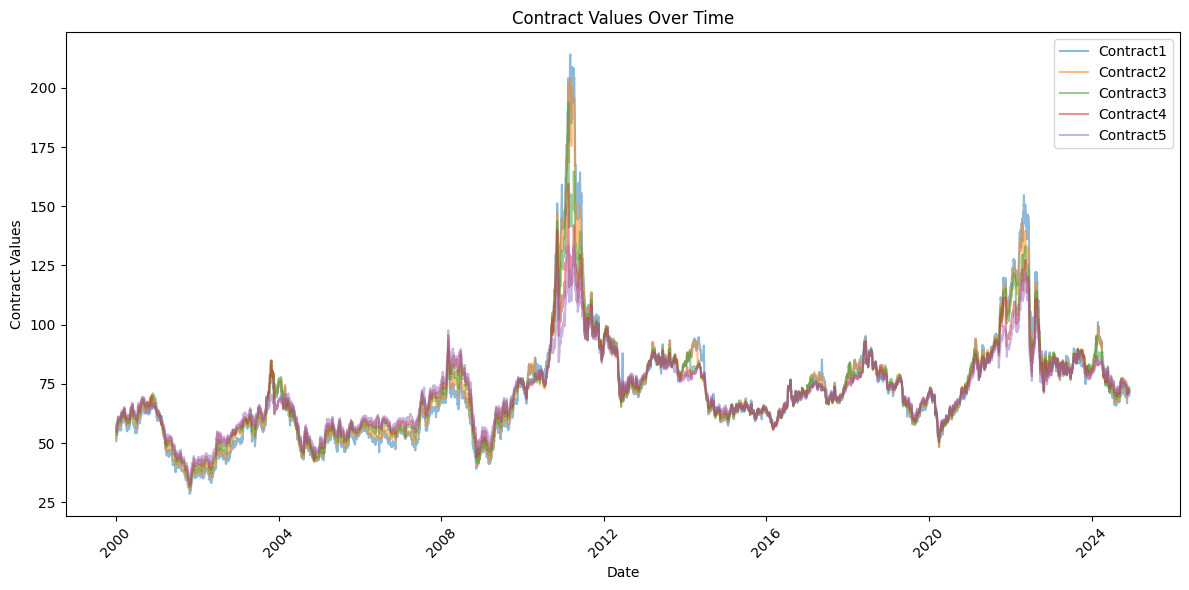

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for col in contract_cols:
    if col in data.columns:
        plt.plot(data['Date'], data[col], label=col, alpha=0.5)
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame. Skipping.")
plt.xlabel('Date')
plt.ylabel('Contract Values')
plt.title('Contract Values Over Time')

#plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
data[contract_cols].describe()

,Contract1,Contract2,Contract3,Contract4,Contract5
count,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000
mean,71.831452,72.086900,71.950010,71.617495,71.373280
std,24.001426,22.068668,19.334309,16.850050,15.091875
min,28.520000,30.220000,31.250000,32.250000,34.000000
25%,56.680000,57.940000,59.120000,60.165000,61.030000
50%,68.380000,69.040000,69.770000,69.950000,69.670000
75%,82.290000,82.070000,81.570000,80.660000,80.005000
max,214.140000,203.970000,193.560000,159.470000,133.390000


## Generating dummy feature for outliers
- ourliers are marked instead of removed
- assuming that time series regression or ML model is able to pick up on the feature and incormporate them in model
- similar approach and shock dummy variables in time series modelling

In [ ]:
def create_dummy_outlier_features(df, cols):
    for col in cols:
        # Calculate mean and standard deviation for the column
        mean = df[col].mean()
        std = df[col].std()

        # Define 3-sigma bounds
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std

        # Create dummy features
        df[f'{col}_outlier_upper'] = np.where(df[col] > upper_bound, 1, 0)  # 1 for upper outlier
        #df[f'{col}_outlier_lower'] = np.where(df[col] < lower_bound, -1, 0)  # -1 for lower outlier

    return df

data = create_dummy_outlier_features(data, contract_cols)

In [ ]:
data

,Date,Contract1,Contract2,Contract3,Contract4,Contract5,DailyReturn,Contract1_outlier_upper,Contract2_outlier_upper,Contract3_outlier_upper,Contract4_outlier_upper,Contract5_outlier_upper
0,2000-01-04,50.73,52.12,53.48,54.80,55.20,NaN,0,0,0,0,0
1,2000-01-05,51.56,52.83,54.10,55.70,56.10,0.016361,0,0,0,0,0
2,2000-01-06,52.08,53.36,54.70,56.10,56.58,0.010085,0,0,0,0,0
3,2000-01-07,53.96,55.09,56.37,57.95,58.42,0.036098,0,0,0,0,0
4,2000-01-10,53.56,54.87,56.10,57.75,58.20,-0.007413,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6250,2024-12-02,71.49,72.65,73.57,72.57,72.27,-0.006117,0,0,0,0,0
6251,2024-12-03,71.27,72.55,73.47,72.51,72.16,-0.003077,0,0,0,0,0
6252,2024-12-04,71.25,72.50,73.43,72.55,72.08,-0.000281,0,0,0,0,0
6253,2024-12-05,71.10,72.38,73.34,72.41,72.00,-0.002105,0,0,0,0,0


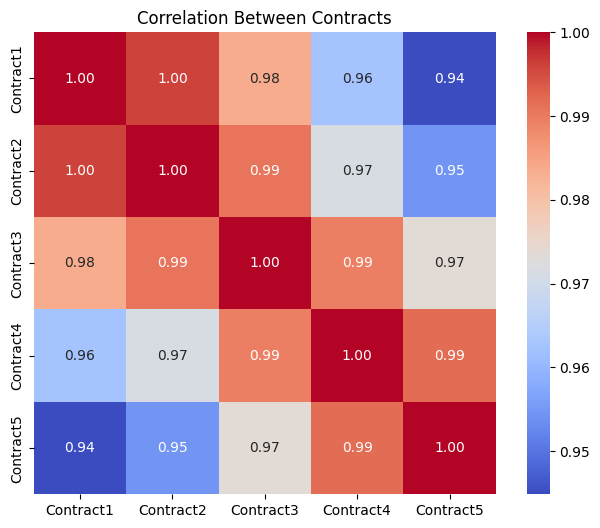

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation = data[[f'Contract{i}' for i in range(1, 6)]].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Between Contracts')
plt.show()

## Returns process and distribution

In [ ]:
import re

In [ ]:
# Calculate Daily Returns for each contract
for i in range(1, 6):
    data[f'DailyReturn_Contract{i}'] = data[f'Contract{i}'] / data[f'Contract{i}'].shift(1) - 1

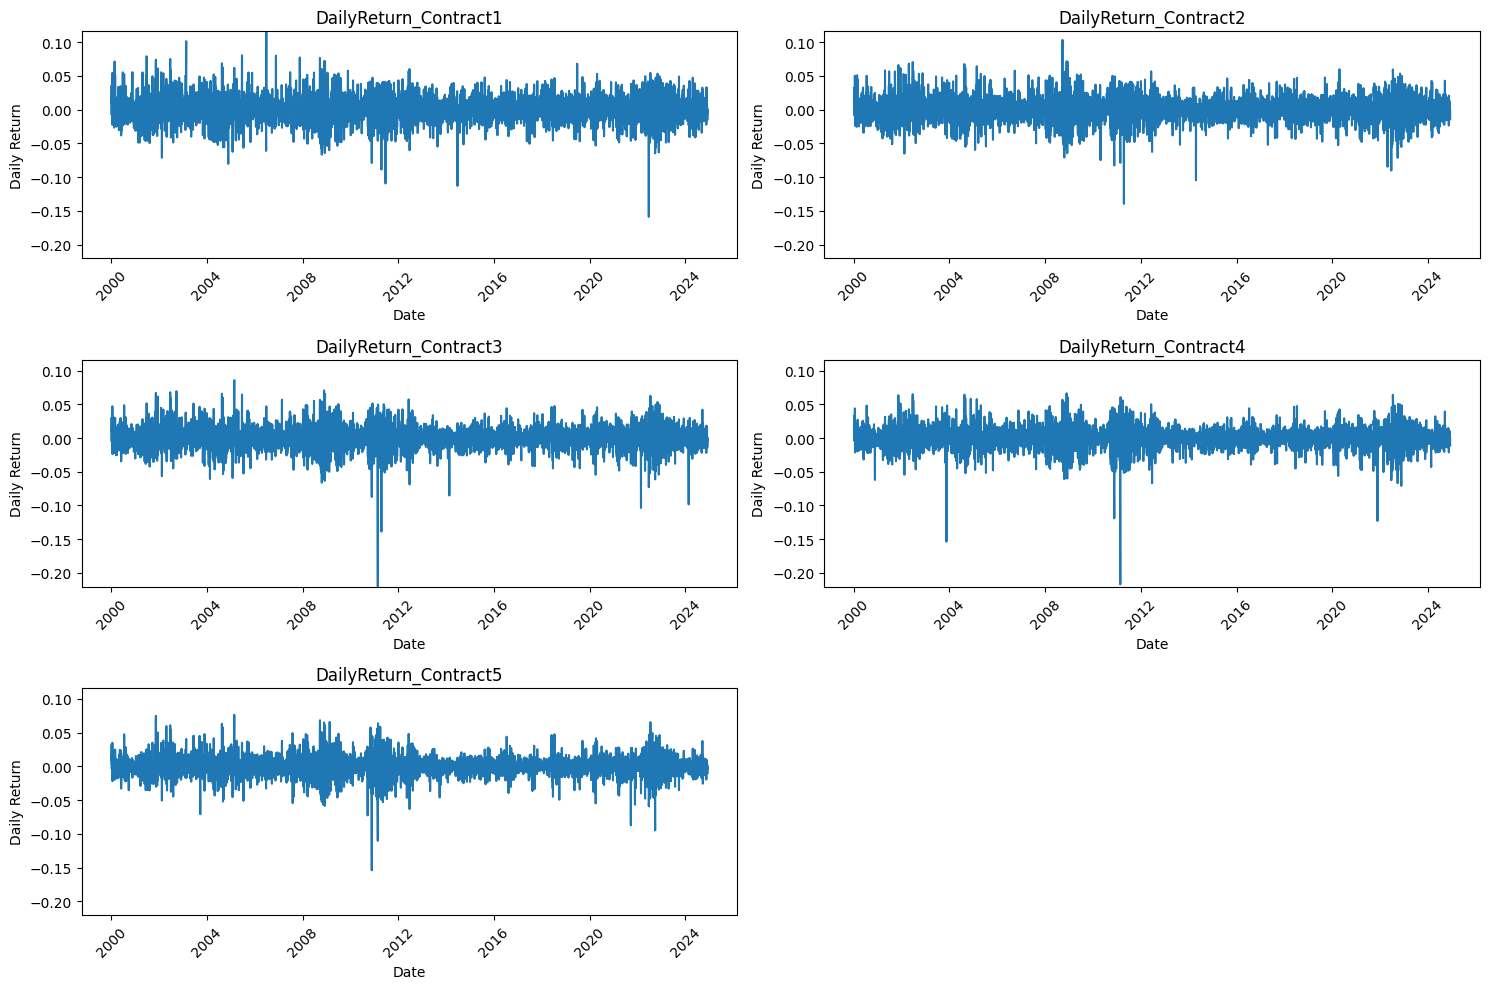

In [ ]:
# Create subplots in two columns
fig, axes = plt.subplots(nrows=len(contract_cols) // 2 + (len(contract_cols) % 2), ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Find columns starting with "DailyReturn_Contract"
daily_return_cols = [col for col in data.columns if re.match(r"^DailyReturn_Contract", col)]

# Access the data in those columns
y_max = data[daily_return_cols].max().max()
y_min = data[daily_return_cols].min().min()

# Access the data in those columns
y_max = data[daily_return_cols].max().max()
y_min = data[daily_return_cols].min().min()

for i, col in enumerate(daily_return_cols):
    if col in data.columns:
        axes[i].plot(data['Date'], data[col])
        axes[i].set_title(col)
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Daily Return')
        axes[i].set_ylim(y_min, y_max)
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Remove empty subplots if the number of contracts isn't even
for i in range(len(daily_return_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

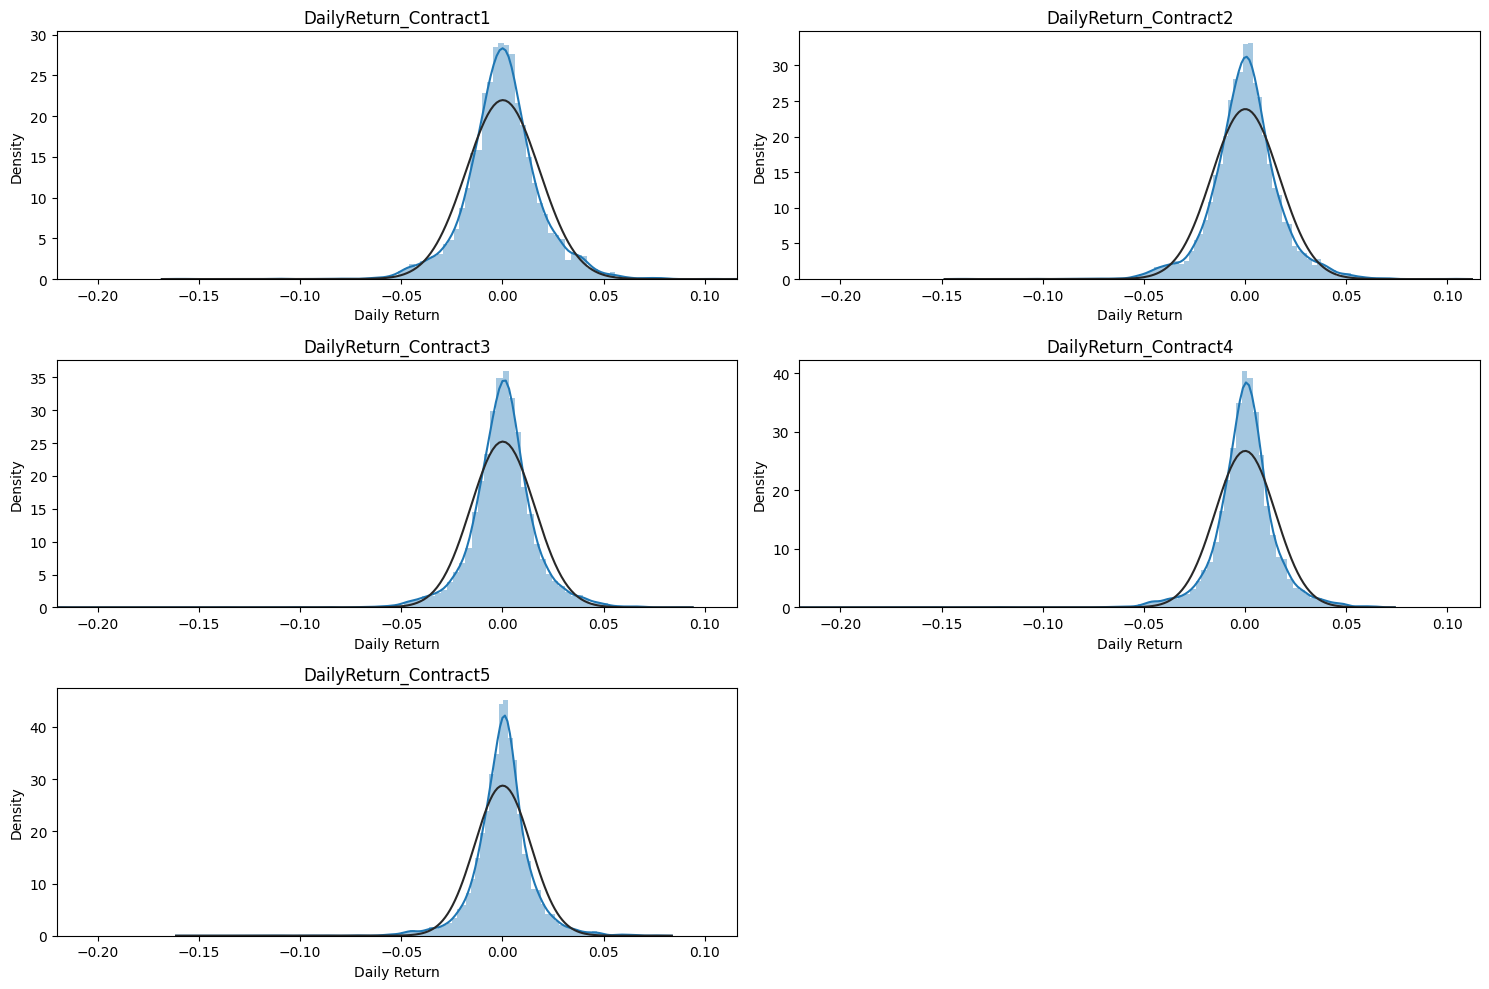

In [ ]:
from scipy.stats import norm
# Create subplots in two columns
fig, axes = plt.subplots(nrows=len(contract_cols) // 2 + (len(contract_cols) % 2), ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Find columns starting with "DailyReturn_Contract"
daily_return_cols = [col for col in data.columns if re.match(r"^DailyReturn_Contract", col)]

# Access the data in those columns
y_max = data[daily_return_cols].max().max()
y_min = data[daily_return_cols].min().min()

for i, col in enumerate(daily_return_cols):
    if col in data.columns:
        sns.distplot(data[col].dropna(), fit=norm, ax=axes[i], bins=100)
        axes[i].set_title(col)
        axes[i].set_xlabel('Daily Return')
        axes[i].set_ylabel('Density')
        axes[i].set_xlim(y_min, y_max)

# Remove empty subplots if the number of contracts isn't even
for i in range(len(daily_return_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
data[daily_return_cols].describe()

,DailyReturn_Contract1,DailyReturn_Contract2,DailyReturn_Contract3,DailyReturn_Contract4,DailyReturn_Contract5
count,6254.000000,6254.000000,6254.000000,6254.000000,6254.000000
mean,0.000217,0.000190,0.000174,0.000155,0.000138
std,0.018170,0.016708,0.015814,0.014921,0.013871
min,-0.158871,-0.139684,-0.220251,-0.216961,-0.154087
25%,-0.009528,-0.008604,-0.007732,-0.006887,-0.006405
50%,0.000000,0.000197,0.000395,0.000463,0.000395
75%,0.009691,0.008851,0.008065,0.007323,0.006710
max,0.116219,0.103487,0.085791,0.066298,0.076523


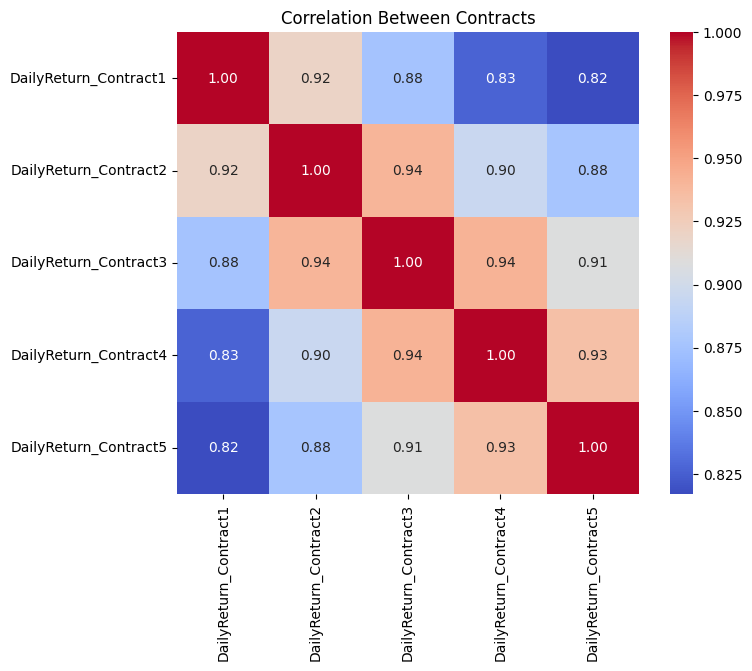

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation = data[daily_return_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Between Contracts')
plt.show()

## Returns normality test
- none of the returns of the contracts is normally distributed
- expected behavior for financial time series

In [ ]:
from scipy.stats import shapiro

def normality_test(df, alpha, fill_na=False):
  # Perform the Shapiro-Wilk test
  if fill_na:
    shapiro_test = shapiro(df.fillna(0))
  else:
    shapiro_test = shapiro(df)

  # Print the test results
  print("Shapiro-Wilk Test:")
  print(f"Statistic: {shapiro_test.statistic}")
  print(f"P-value: {shapiro_test.pvalue}")

  # Interpret the results
  if shapiro_test.pvalue > alpha:
      print("Sample looks Gaussian (fail to reject H0)")
  else:
      print("Sample does not look Gaussian (reject H0)")

In [ ]:
# Loop through each column starting with "DailyReturn_Contract"
for col in data.columns:
    if col.startswith("DailyReturn_Contract"):
        print(f"Normality test for {col}:")
        normality_test(data[col], 0.05, fill_na=True)
        print("\n")

Normality test for DailyReturn_Contract1:
Shapiro-Wilk Test:
Statistic: 0.9728356002940642
P-value: 7.443562297335548e-33
Sample does not look Gaussian (reject H0)


Normality test for DailyReturn_Contract2:
Shapiro-Wilk Test:
Statistic: 0.9702813572174526
P-value: 4.22750127972542e-34
Sample does not look Gaussian (reject H0)


Normality test for DailyReturn_Contract3:
Shapiro-Wilk Test:
Statistic: 0.9449952816170023
P-value: 2.742209154463659e-43
Sample does not look Gaussian (reject H0)


Normality test for DailyReturn_Contract4:
Shapiro-Wilk Test:
Statistic: 0.9286957985023894
P-value: 1.6686507600113687e-47
Sample does not look Gaussian (reject H0)


Normality test for DailyReturn_Contract5:
Shapiro-Wilk Test:
Statistic: 0.9367848666469949
P-value: 1.5977682145891784e-45
Sample does not look Gaussian (reject H0)




# TASK 2: Volatility analysis
- calculating volatility on 20d window
- calculating spreads and ratios

In [ ]:
import itertools
# Task 2: Volatility Analysis
# --------------------------------------------
# Calculate Rolling Standard Deviations (20-day window)
volatility_data = data.copy()
for i in range(1, 6):
    volatility_data[f'Volatility_Contract{i}'] = data[f'Contract{i}'].rolling(window=20).std()
    volatility_data[f'Mean_Contract{i}'] = data[f'Contract{i}'].rolling(window=20).mean()

data = volatility_data.copy(deep=True)

# Calculate spreads and ratios for every combination of contracts
contract_combinations = list(itertools.combinations(range(1, 6), 2))
for c1, c2 in contract_combinations:
    data[f'Spread_Contract{c1}_Contract{c2}'] = data[f'Contract{c1}'] - data[f'Contract{c2}']
    data[f'Ratio_Contract{c1}_Contract{c2}'] = data[f'Contract{c1}'] / data[f'Contract{c2}']

## Volatility - 20D moving window

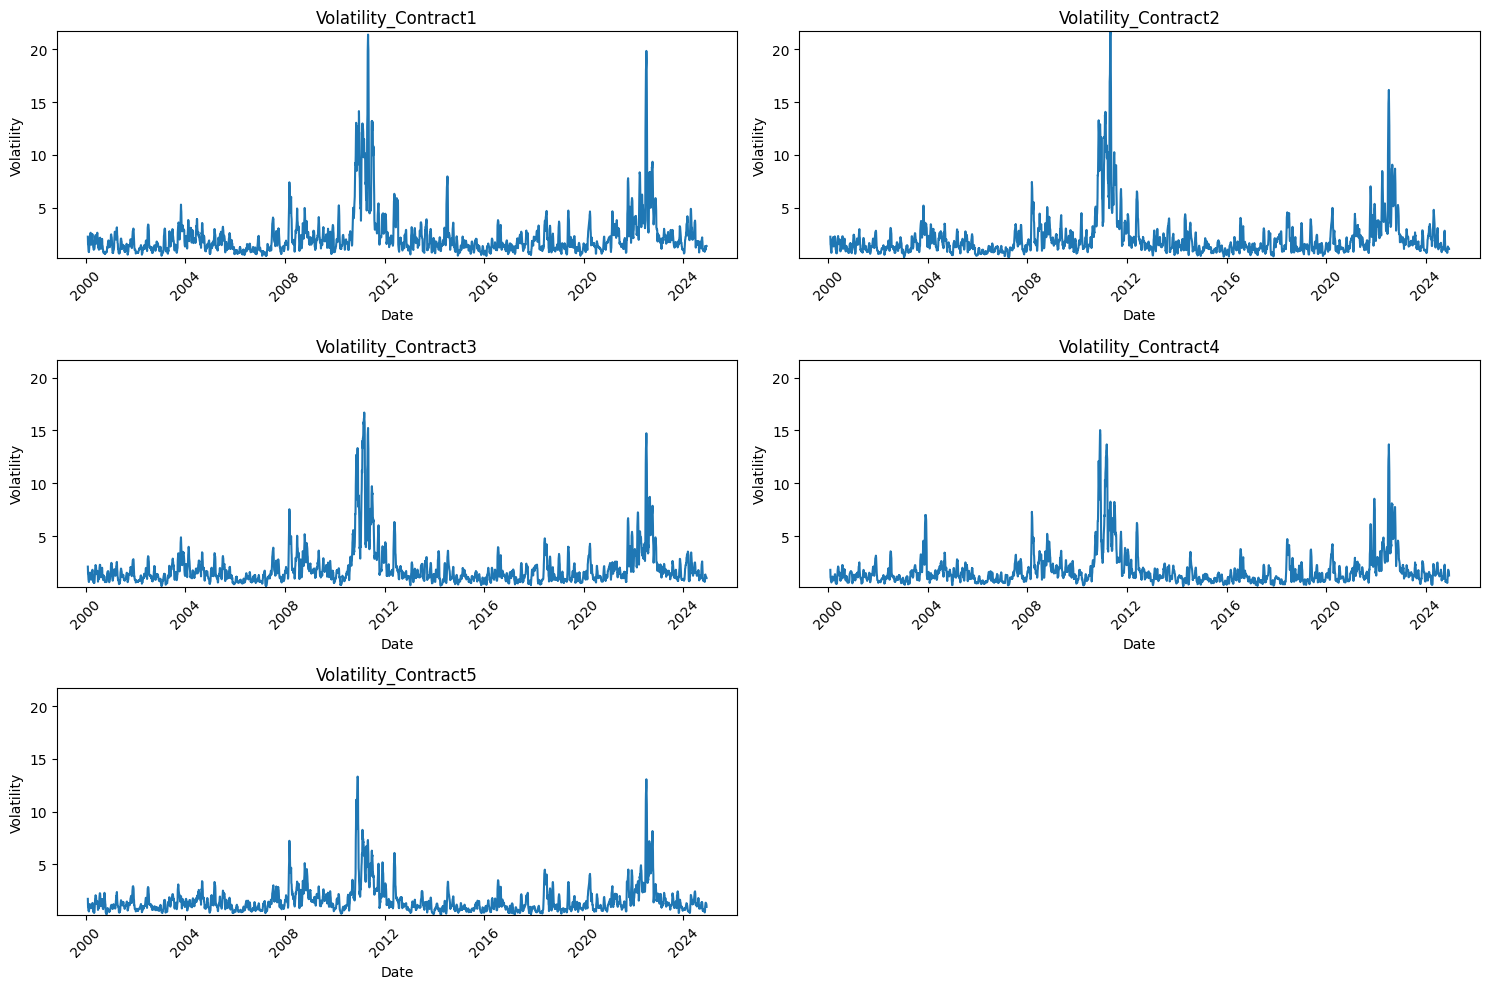

In [ ]:
# Create subplots in two columns
fig, axes = plt.subplots(nrows=len(contract_cols) // 2 + (len(contract_cols) % 2), ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Find columns starting with "Spread_Contract"
spread_contract_cols = [col for col in volatility_data.columns if re.match(r"^Volatility_Contract", col)]

# Access the data in those columns
y_max = volatility_data[spread_contract_cols].max().max()
y_min = volatility_data[spread_contract_cols].min().min()

for i, col in enumerate(contract_cols):
    volatility_col = f'Volatility_{col}'
    if volatility_col in volatility_data.columns:
        axes[i].plot(volatility_data['Date'], volatility_data[volatility_col])
        axes[i].set_title(volatility_col)
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Volatility')
        axes[i].set_ylim(y_min, y_max)
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels


# Remove empty subplots if the number of contracts isn't even
for i in range(len(contract_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
volatility_data[spread_contract_cols].describe()

,Volatility_Contract1,Volatility_Contract2,Volatility_Contract3,Volatility_Contract4,Volatility_Contract5
count,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000
mean,2.268502,2.111199,1.953823,1.778526,1.603063
std,2.081062,1.966390,1.855890,1.628925,1.353296
min,0.437795,0.294563,0.255619,0.284262,0.221844
25%,1.205474,1.105749,1.000576,0.915742,0.843159
50%,1.702872,1.552552,1.445461,1.310262,1.223062
75%,2.529708,2.330844,2.148786,1.966449,1.843207
max,21.396398,21.704426,16.698110,15.036980,13.316243


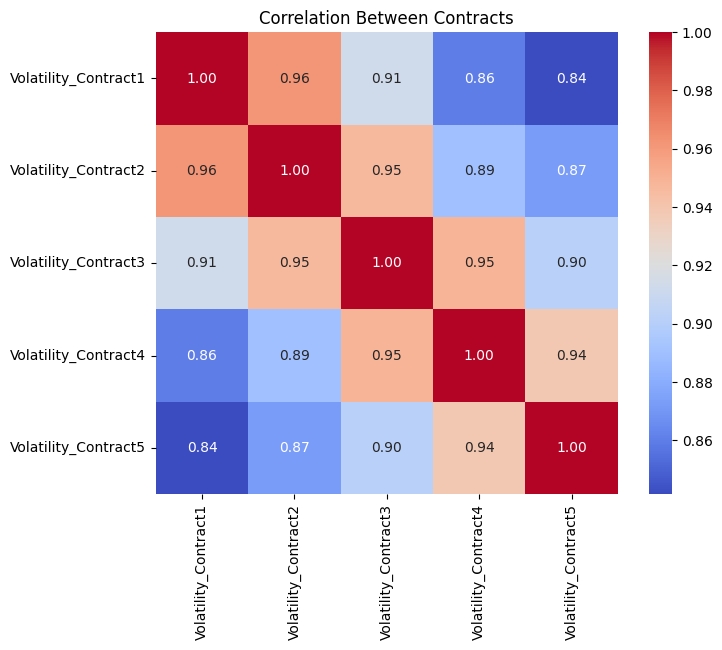

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation = volatility_data[spread_contract_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Between Contracts')
plt.show()

## Contract Spreads

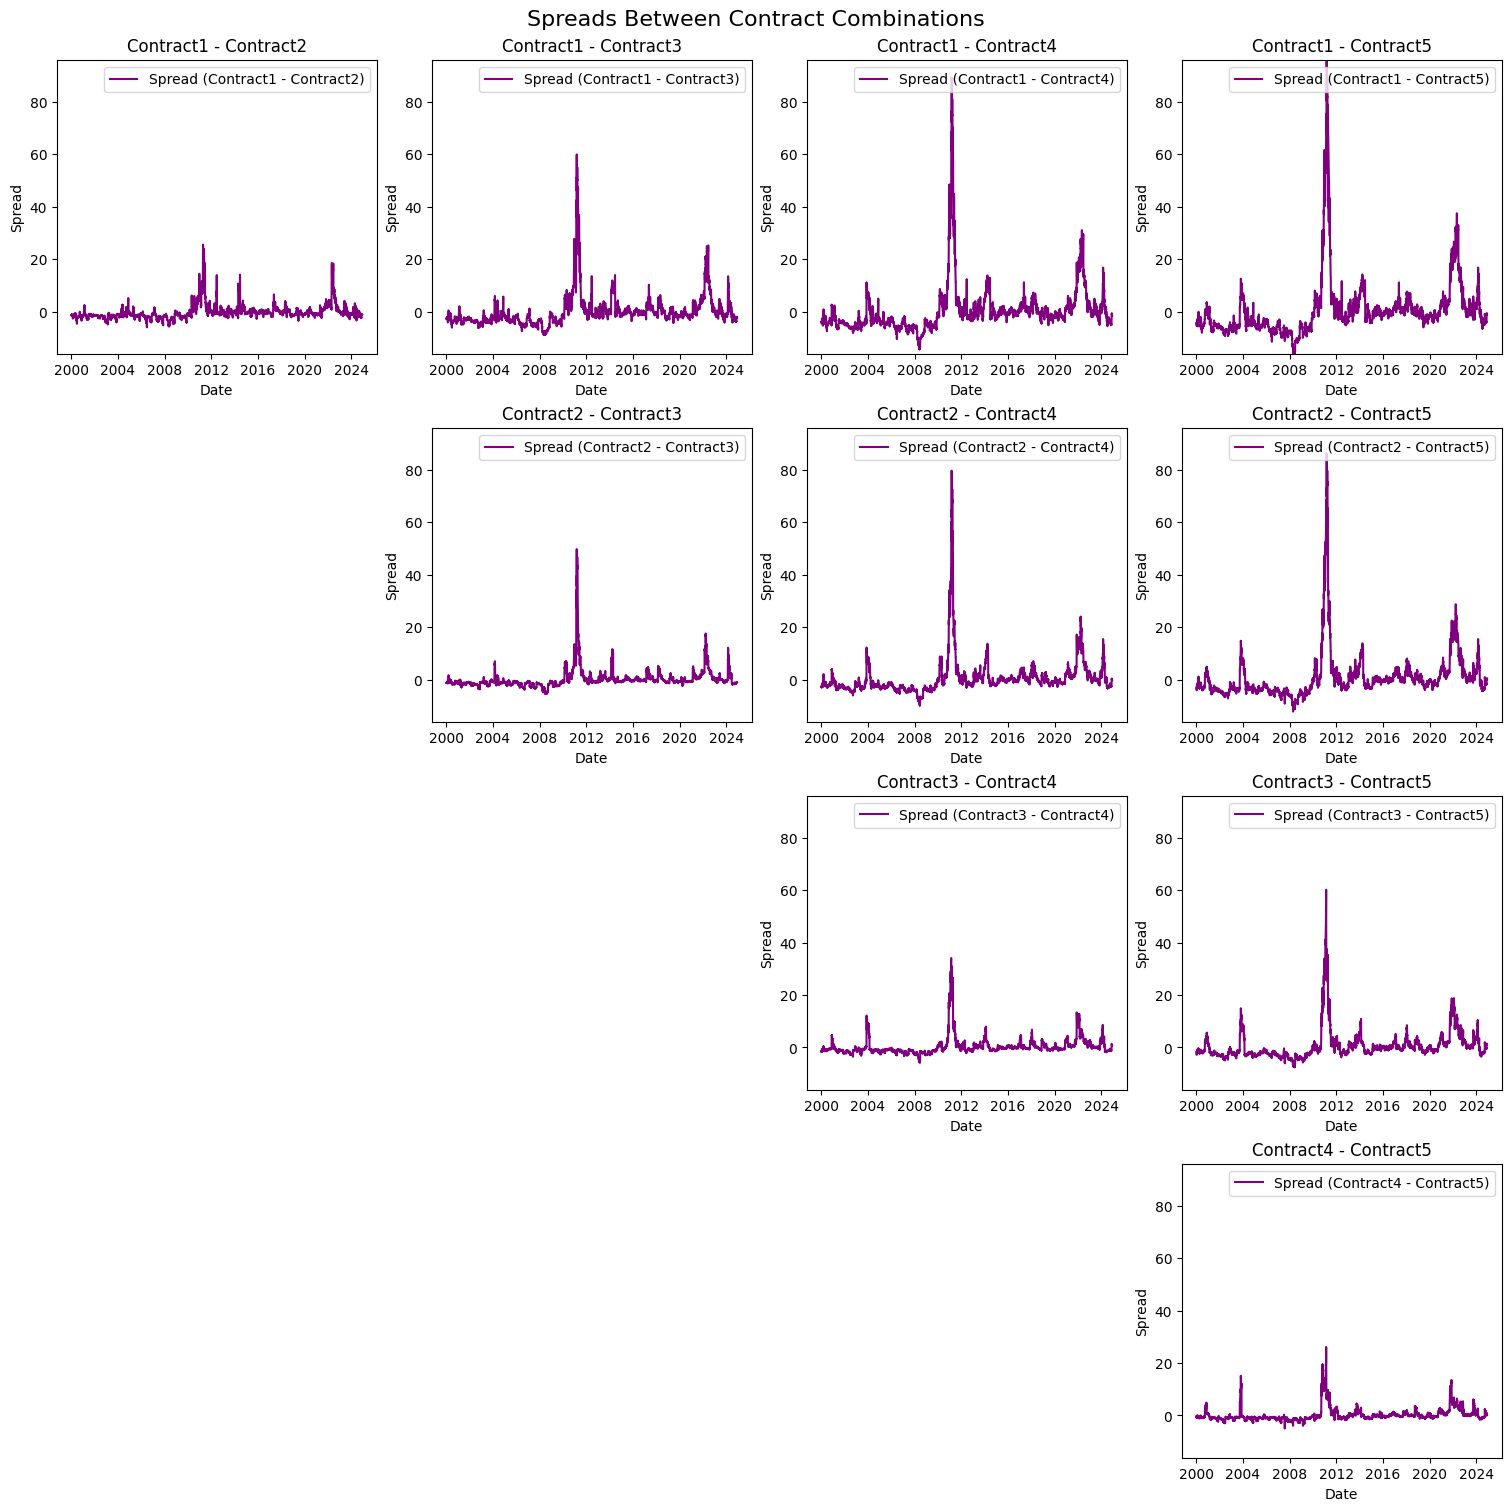

In [ ]:
# Visualization: Plot Spreads for Contract Combinations
num_contracts = 5
fig, axes = plt.subplots(num_contracts - 1, num_contracts - 1, figsize=(15, 15), constrained_layout=True)

# Find columns starting with "Spread_Contract"
spread_contract_cols = [col for col in data.columns if re.match(r"^Spread_Contract", col)]

# Access the data in those columns
y_max = data[spread_contract_cols].max().max()
y_min = data[spread_contract_cols].min().min()

for i in range(1, num_contracts):
    for j in range(i + 1, num_contracts + 1):
        ax = axes[i - 1, j - 2]
        ax.plot(data['Date'], data[f'Spread_Contract{i}_Contract{j}'], label=f'Spread (Contract{i} - Contract{j})', color='purple')
        ax.set_title(f'Contract{i} - Contract{j}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Spread')
        ax.set_ylim(y_min, y_max)
        ax.legend()

# Hide unused subplots
for i in range(num_contracts - 1):
    for j in range(i):
        axes[i, j].axis('off')

plt.suptitle('Spreads Between Contract Combinations', fontsize=16)
plt.show()

In [ ]:
data[spread_contract_cols].describe()

,Spread_Contract1_Contract2,Spread_Contract1_Contract3,Spread_Contract1_Contract4,Spread_Contract1_Contract5,Spread_Contract2_Contract3,Spread_Contract2_Contract4,Spread_Contract2_Contract5,Spread_Contract3_Contract4,Spread_Contract3_Contract5,Spread_Contract4_Contract5
count,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000
mean,-0.255448,-0.118558,0.213957,0.458172,0.136890,0.469405,0.713620,0.332515,0.576730,0.244215
std,2.834384,6.089135,9.027341,10.923444,3.903591,6.975380,8.892643,3.599686,5.780328,2.697013
min,-5.990000,-8.910000,-14.400000,-16.150000,-5.490000,-10.040000,-12.230000,-5.870000,-7.580000,-5.000000
25%,-1.640000,-3.080000,-4.285000,-5.270000,-1.330000,-2.645000,-3.660000,-1.150000,-2.280000,-1.000000
50%,-0.810000,-1.390000,-1.430000,-1.300000,-0.700000,-1.040000,-0.970000,-0.520000,-0.810000,-0.490000
75%,0.240000,0.785000,1.440000,1.955000,0.380000,1.150000,1.915000,0.540000,1.240000,0.440000
max,25.540000,59.930000,89.390000,95.970000,49.760000,79.660000,86.240000,34.090000,60.170000,26.080000


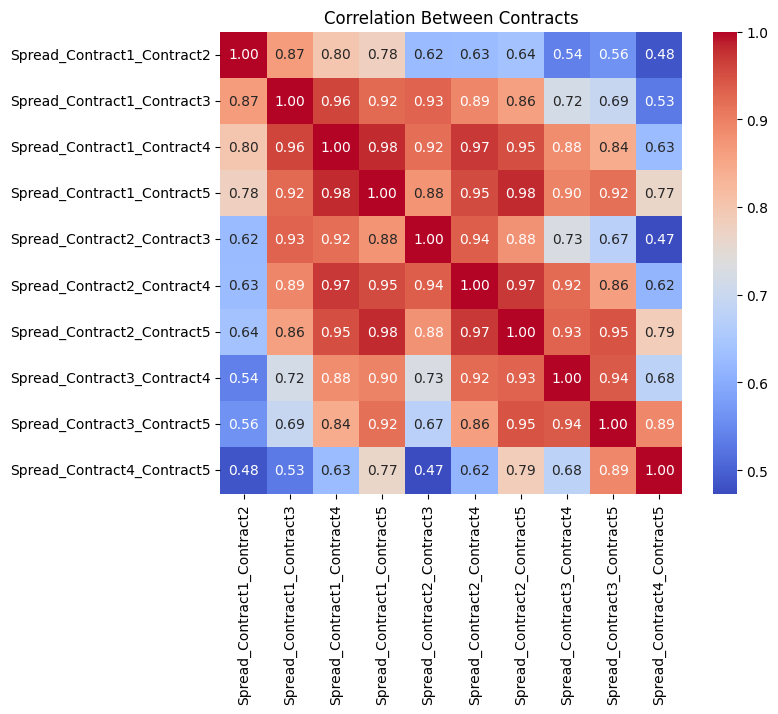

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation = data[spread_contract_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Between Contracts')
plt.show()

## Contract Ratios

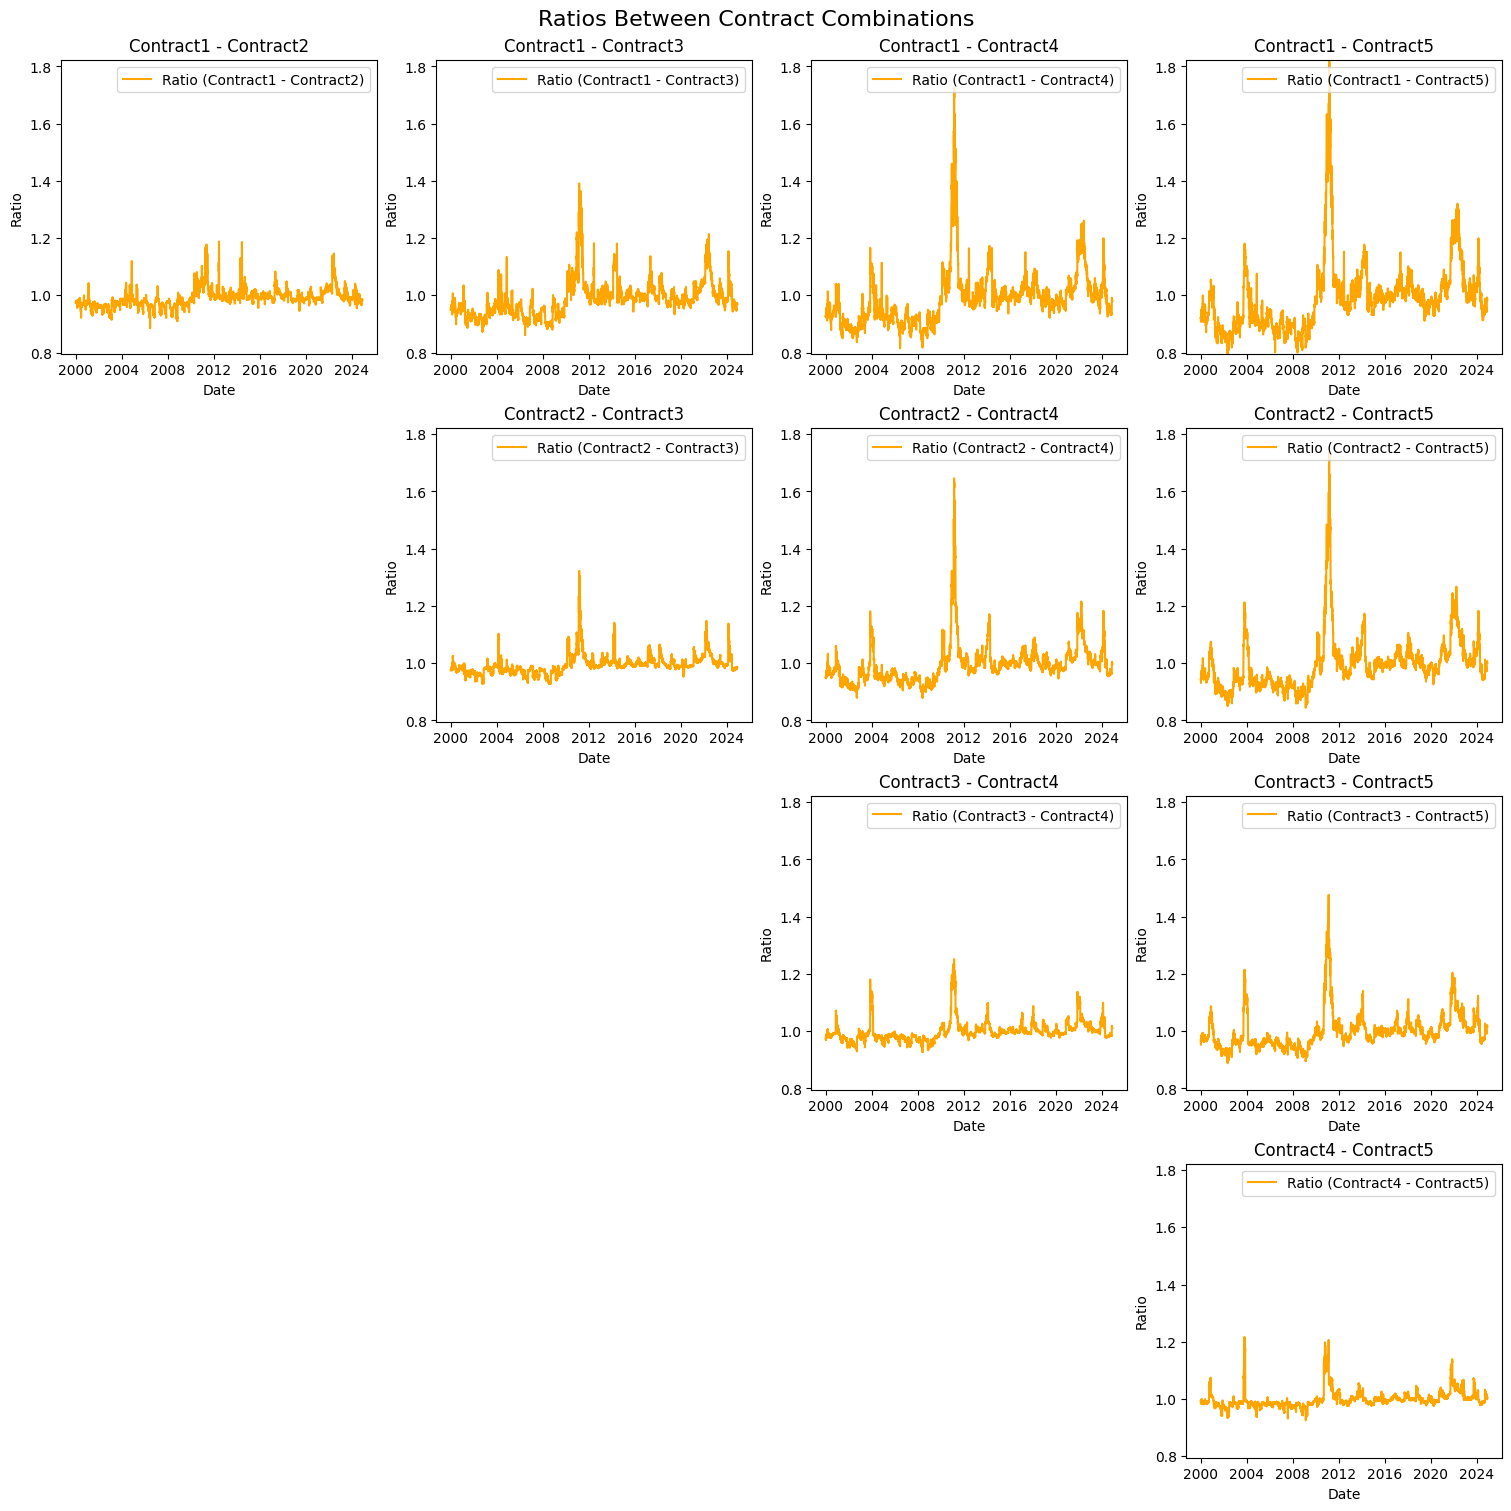

In [ ]:
# Visualization: Plot Ratio for Contract Combinations
num_contracts = 5
fig, axes = plt.subplots(num_contracts - 1, num_contracts - 1, figsize=(15, 15), constrained_layout=True)

# Find columns starting with "Spread_Contract"
spread_contract_cols = [col for col in data.columns if re.match(r"^Ratio_Contract", col)]

# Access the data in those columns
y_max = data[spread_contract_cols].max().max()
y_min = data[spread_contract_cols].min().min()

for i in range(1, num_contracts):
    for j in range(i + 1, num_contracts + 1):
        ax = axes[i - 1, j - 2]
        ax.plot(data['Date'], data[f'Ratio_Contract{i}_Contract{j}'], label=f'Ratio (Contract{i} - Contract{j})', color='orange')
        ax.set_title(f'Contract{i} - Contract{j}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Ratio')
        ax.set_ylim(y_min, y_max)
        ax.legend()

# Hide unused subplots
for i in range(num_contracts - 1):
    for j in range(i):
        axes[i, j].axis('off')

plt.suptitle('Ratios Between Contract Combinations', fontsize=16)
plt.show()

In [ ]:
data[spread_contract_cols].describe()

,Ratio_Contract1_Contract2,Ratio_Contract1_Contract3,Ratio_Contract1_Contract4,Ratio_Contract1_Contract5,Ratio_Contract2_Contract3,Ratio_Contract2_Contract4,Ratio_Contract2_Contract5,Ratio_Contract3_Contract4,Ratio_Contract3_Contract5,Ratio_Contract4_Contract5
count,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000
mean,0.990490,0.986364,0.986730,0.987779,0.995149,0.994935,0.995541,0.998911,0.998964,0.999350
std,0.032004,0.061309,0.092172,0.116260,0.036264,0.068732,0.093106,0.036605,0.062599,0.031297
min,0.885051,0.860769,0.814841,0.794958,0.927288,0.878721,0.844030,0.926881,0.887875,0.925474
25%,0.972028,0.948493,0.926109,0.910135,0.977135,0.955215,0.937957,0.981219,0.962976,0.983476
50%,0.988371,0.979945,0.979316,0.981355,0.989871,0.984735,0.985813,0.992388,0.988045,0.992794
75%,1.003240,1.010221,1.018107,1.025075,1.004828,1.014082,1.024637,1.006950,1.015581,1.005634
max,1.188116,1.390668,1.724921,1.822154,1.322677,1.646014,1.738799,1.251318,1.476066,1.216966


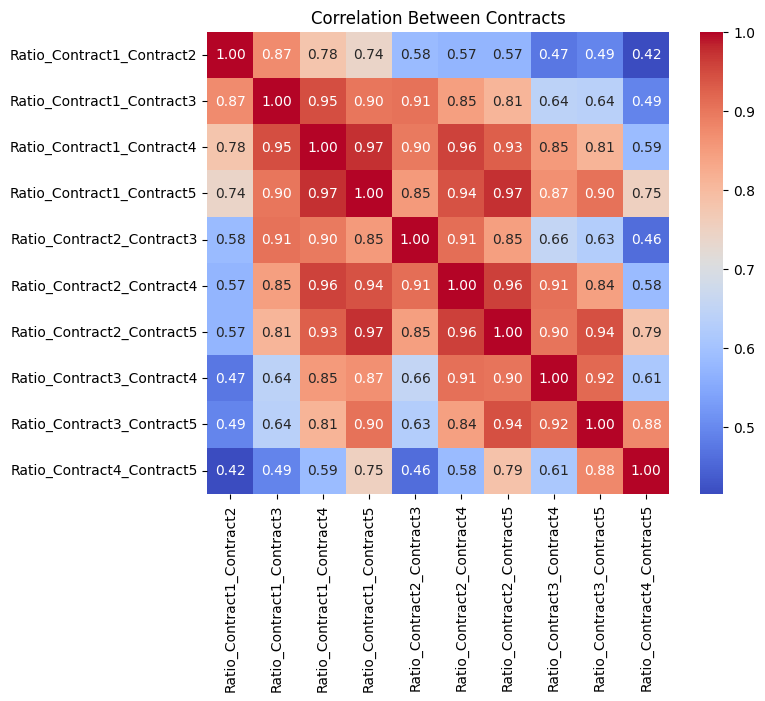

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation = data[spread_contract_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Between Contracts')
plt.show()

# Feature engineering

## Autocorrelations
- plottingcorrelograms to identify potential AR processes in time series
- AR(2) seems to be most likely present in contract prices
  - lags are being added in section Volatility analysis alongside other ratios

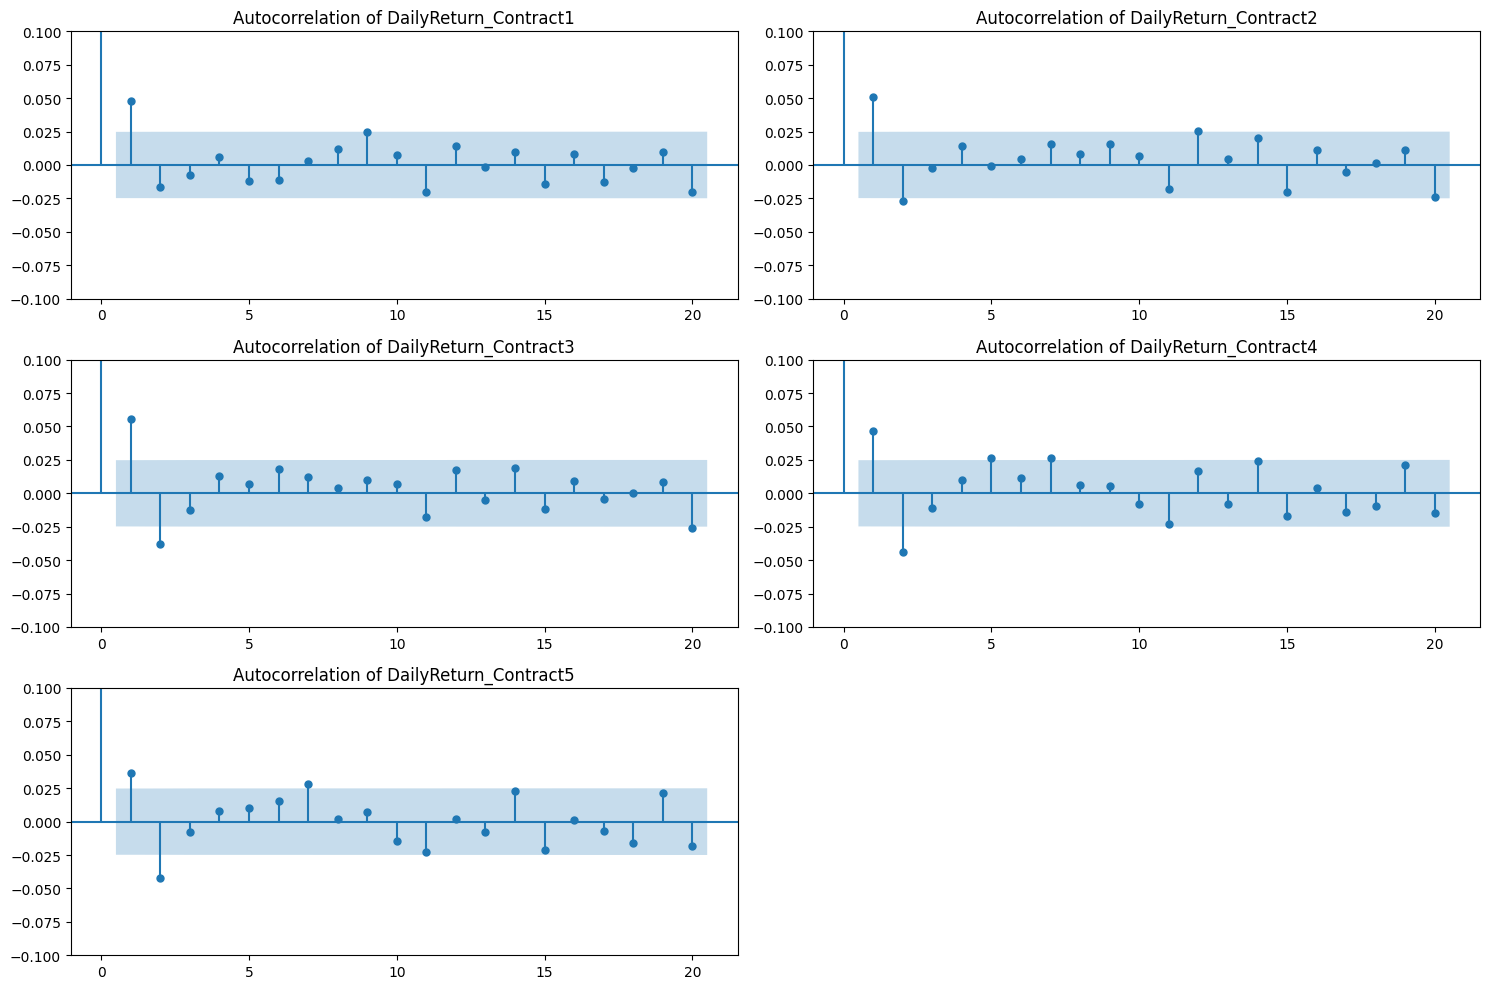

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Find columns starting with "DailyReturn_Contract"
daily_return_cols = [col for col in data.columns if re.match(r"^DailyReturn_Contract", col)]

# Create subplots in two columns
fig, axes = plt.subplots(nrows=len(daily_return_cols) // 2 + (len(daily_return_cols) % 2), ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(daily_return_cols):
    plot_acf(data[col].dropna(), ax=axes[i], lags=20)  # Adjust lags as needed
    axes[i].set_title(f'Autocorrelation of {col}')
    axes[i].set_ylim(-0.1, 0.1)  # Set y-axis limits

# Remove empty subplots if the number of contracts isn't even
for i in range(len(daily_return_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
data

,Date,Contract1,Contract2,Contract3,Contract4,Contract5,DailyReturn,Contract1_outlier_upper,Contract2_outlier_upper,Contract3_outlier_upper,...,Spread_Contract2_Contract4,Ratio_Contract2_Contract4,Spread_Contract2_Contract5,Ratio_Contract2_Contract5,Spread_Contract3_Contract4,Ratio_Contract3_Contract4,Spread_Contract3_Contract5,Ratio_Contract3_Contract5,Spread_Contract4_Contract5,Ratio_Contract4_Contract5
0,2000-01-04,50.73,52.12,53.48,54.80,55.20,NaN,0,0,0,...,-2.68,0.951095,-3.08,0.944203,-1.32,0.975912,-1.72,0.968841,-0.40,0.992754
1,2000-01-05,51.56,52.83,54.10,55.70,56.10,0.016361,0,0,0,...,-2.87,0.948474,-3.27,0.941711,-1.60,0.971275,-2.00,0.964349,-0.40,0.992870
2,2000-01-06,52.08,53.36,54.70,56.10,56.58,0.010085,0,0,0,...,-2.74,0.951159,-3.22,0.943089,-1.40,0.975045,-1.88,0.966773,-0.48,0.991516
3,2000-01-07,53.96,55.09,56.37,57.95,58.42,0.036098,0,0,0,...,-2.86,0.950647,-3.33,0.942999,-1.58,0.972735,-2.05,0.964909,-0.47,0.991955
4,2000-01-10,53.56,54.87,56.10,57.75,58.20,-0.007413,0,0,0,...,-2.88,0.950130,-3.33,0.942784,-1.65,0.971429,-2.10,0.963918,-0.45,0.992268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,2024-12-02,71.49,72.65,73.57,72.57,72.27,-0.006117,0,0,0,...,0.08,1.001102,0.38,1.005258,1.00,1.013780,1.30,1.017988,0.30,1.004151
6251,2024-12-03,71.27,72.55,73.47,72.51,72.16,-0.003077,0,0,0,...,0.04,1.000552,0.39,1.005405,0.96,1.013240,1.31,1.018154,0.35,1.004850
6252,2024-12-04,71.25,72.50,73.43,72.55,72.08,-0.000281,0,0,0,...,-0.05,0.999311,0.42,1.005827,0.88,1.012130,1.35,1.018729,0.47,1.006521
6253,2024-12-05,71.10,72.38,73.34,72.41,72.00,-0.002105,0,0,0,...,-0.03,0.999586,0.38,1.005278,0.93,1.012844,1.34,1.018611,0.41,1.005694


## Streaks

In [ ]:
streaks_df = pd.DataFrame()
# Calculate Daily Returns for each contract
for i in range(1, 6):
    streaks_df = pd.DataFrame()

    streaks_df[f'Streak_Contract{i}'] = streak_counter(data[f'Contract{i}'])
    data = data.merge(streaks_df, left_index=True, right_index=True, how='left').copy(deep=True)

    data[f'Streak_Contract{i}'] = np.where(
        data[f'DailyReturn_Contract{i}'] > 0,
        data[f'Streak_Contract{i}'],
        -data[f'Streak_Contract{i}']
    )

In [ ]:
data[['Streak_Contract1']]

,Streak_Contract1
0,-1
1,1
2,2
3,3
4,-1
...,...
6250,-1
6251,-2
6252,-3
6253,-4


## Technical indicators
- expanding data with technical indicators that
  1. does not require Volume data
  2. does not require OHLC structure

In [ ]:
indicators = [
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'momentum_rsi',
 'momentum_stoch_rsi',
 'momentum_stoch_rsi_k',
 'momentum_stoch_rsi_d',
]

In [ ]:
ta_all_contracts = pd.DataFrame()
ta_contract = pd.DataFrame()
ta_input = data.iloc[:,0:6].copy(deep=True)
for i in range(1, 6):
  ta_contract['Close'] = ta_input[f'Contract{i}']#.iloc[:,i-1:i]

  # abusing ta.add_all_ta_features to calculate indicators without OHLC structure and volumes
  ta_contract['Open'] = ta_contract['High'] = ta_contract['Low'] = ta_contract['Close']
  ta_contract['Volume'] = 1
  ta_contract = ta.add_all_ta_features(ta_contract, open="Open", high="High", low="Low", close="Close", volume="Volume")

  # selecting OHLC and volume independent indicators
  ta_contract = ta_contract[indicators]
  for col in ta_contract.columns:
    ta_contract.rename(columns={col: f'{col}_Contract{i}'}, inplace=True)

  # concating indicators for each contract to remaining df
  ta_all_contracts = pd.concat([ta_all_contracts, ta_contract], axis=1)

data = data.merge(ta_all_contracts, left_index=True, right_index=True, how='left').copy(deep=True)

#ta_all_contracts

## Seasonality features
- adding monthly dummy variables for seasonal effects

In [ ]:
# Assuming your dataframe is named 'data' and has a 'Date' column
data['Month'] = data['Date'].dt.month

# Create dummy variables for each month
month_dummies = pd.get_dummies(data['Month'], prefix='Month')
data = pd.concat([data, month_dummies], axis=1)

## Lags
- creating lagged features for contract prices
- other lags (for lagged contract spreads and ratios) were tested but did not produce any noticeable model uplift

# Create lagged features
for i in range(1, 6):
    data[f'Lag1_Contract{i}'] = data[f'Contract{i}'].shift(1)
    data[f'Lag2_Contract{i}'] = data[f'Contract{i}'].shift(2)

In [ ]:
# Feature Engineering
# Create lagged features and engineered spreads/ratios
for i in range(1, 6):
    data[f'Lag1_Contract{i}'] = data[f'Contract{i}'].shift(1)
    data[f'Lag2_Contract{i}'] = data[f'Contract{i}'].shift(2)
    data[f'Lag3_Contract{i}'] = data[f'Contract{i}'].shift(3)
    data[f'Lag4_Contract{i}'] = data[f'Contract{i}'].shift(4)
    data[f'Lag5_Contract{i}'] = data[f'Contract{i}'].shift(5)

In [ ]:
data

,Date,Contract1,Contract2,Contract3,Contract4,Contract5,DailyReturn,Contract1_outlier_upper,Contract2_outlier_upper,Contract3_outlier_upper,...,Lag1_Contract4,Lag2_Contract4,Lag3_Contract4,Lag4_Contract4,Lag5_Contract4,Lag1_Contract5,Lag2_Contract5,Lag3_Contract5,Lag4_Contract5,Lag5_Contract5
0,2000-01-04,50.73,52.12,53.48,54.80,55.20,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-05,51.56,52.83,54.10,55.70,56.10,0.016361,0,0,0,...,54.80,NaN,NaN,NaN,NaN,55.20,NaN,NaN,NaN,NaN
2,2000-01-06,52.08,53.36,54.70,56.10,56.58,0.010085,0,0,0,...,55.70,54.80,NaN,NaN,NaN,56.10,55.20,NaN,NaN,NaN
3,2000-01-07,53.96,55.09,56.37,57.95,58.42,0.036098,0,0,0,...,56.10,55.70,54.80,NaN,NaN,56.58,56.10,55.20,NaN,NaN
4,2000-01-10,53.56,54.87,56.10,57.75,58.20,-0.007413,0,0,0,...,57.95,56.10,55.70,54.80,NaN,58.42,56.58,56.10,55.20,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,2024-12-02,71.49,72.65,73.57,72.57,72.27,-0.006117,0,0,0,...,73.01,72.88,72.93,72.33,71.65,72.58,72.39,72.37,72.27,71.71
6251,2024-12-03,71.27,72.55,73.47,72.51,72.16,-0.003077,0,0,0,...,72.57,73.01,72.88,72.93,72.33,72.27,72.58,72.39,72.37,72.27
6252,2024-12-04,71.25,72.50,73.43,72.55,72.08,-0.000281,0,0,0,...,72.51,72.57,73.01,72.88,72.93,72.16,72.27,72.58,72.39,72.37
6253,2024-12-05,71.10,72.38,73.34,72.41,72.00,-0.002105,0,0,0,...,72.55,72.51,72.57,73.01,72.88,72.08,72.16,72.27,72.58,72.39


# TASK 3 and 4: Model

Model is composed in following architecture

1. Hidden Markov Chains
  - used for mode switching
  - HMM model is fit and generates likelihood of the hidden state
  - hidden state is added to the `data` dataframe as feature
2. Support-Vector Machine
  - used for binary clasification of rise of fall of the spread
  - strict training separation is implemented in order to not leak information in between training and testing sets
  - binary prediction is then added to the `data` dataframe as feature
3. Long-Short Term Memory Neural Network
  - used to predict the level of the spread
  - model utilizes features generated by previous models in order to maximize ther predicitive power
  - strict training separation is implemented in order to not leak information in between training and testing sets

In [ ]:
backup_data = data.copy(deep=True)

last controll of the NaN.
- some missing values, due to the lagged or windowed features are to be expected

In [ ]:
# Calculate the NaN ratio for each column
nan_ratios = pd.DataFrame()
nan_ratios['ratio'] = data.isnull().sum() / len(data)
nan_ratios['count'] = data.isnull().sum()

# Sort the NaN ratios in descending order
nan_ratios.sort_values(by = 'ratio', ascending=False)

,ratio,count
trend_macd_diff_Contract3,0.005276,33
trend_macd_signal_Contract5,0.005276,33
trend_macd_diff_Contract1,0.005276,33
trend_macd_signal_Contract1,0.005276,33
trend_macd_diff_Contract2,0.005276,33
...,...,...
Contract2_outlier_upper,0.000000,0
Contract1_outlier_upper,0.000000,0
Streak_Contract4,0.000000,0
Month_1,0.000000,0


checking that no NaN values appear beyond expected lag or window period

In [ ]:
subset = data.iloc[50:,:].copy(deep=True)

# Display rows with any NaN values
subset[subset.isnull().any(axis=1)]

,Date,Contract1,Contract2,Contract3,Contract4,Contract5,DailyReturn,Contract1_outlier_upper,Contract2_outlier_upper,Contract3_outlier_upper,...,Lag1_Contract4,Lag2_Contract4,Lag3_Contract4,Lag4_Contract4,Lag5_Contract4,Lag1_Contract5,Lag2_Contract5,Lag3_Contract5,Lag4_Contract5,Lag5_Contract5


In [ ]:
data = backup_data.copy(deep=True)

In [ ]:
data.shape

(6255, 145)

removing NaN rows and setting targets

In [ ]:
# Load and preprocess data
data['Future_DailyReturn'] = data['Spread_Contract1_Contract5'].shift(-1)
data['Target'] = (data['Future_DailyReturn'] > 0).astype(int)
data = data.dropna().reset_index(drop=True)

In [ ]:
data.shape

(6221, 147)

## Hidden Markov Chain clusters

In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from hmmlearn.hmm import GaussianHMM

# Generate HMM-based features
def generate_hmm_feature(train_series, test_series, n_states=3):
    # Assuming series is a DataFrame with multiple columns (features)
    train_series = train_series.values  # Convert to NumPy array (handles multiple columns)
    model = GaussianHMM(n_components=n_states, covariance_type="diag", random_state=42, n_iter=100)
    model.fit(train_series)  # Fit the HMM model
    return model.predict(test_series)  # Predict hidden states

# Initialize output DataFrame for predictions
mcc_output = pd.DataFrame()

# Set up TimeSeriesSplit with 5 folds
tscv = TimeSeriesSplit(n_splits=5)

# Loop through each contract (assuming 5 contracts as per your description)
for i in range(1, 6):
    contract_col = f'DailyReturn_Contract{i}'
    mcc_feature_col = f'VLMC_Feature_Contract{i}'

    # Prepare input data, excluding unnecessary columns
    mcc_input = data.drop(columns=['Date', 'DailyReturn', contract_col])

    fold_predictions = []  # To collect predictions for all folds
    for i, (train_index, test_index) in enumerate(tscv.split(mcc_input)):
        # Split data into train and test sets
        X_train, X_test = mcc_input.iloc[train_index], mcc_input.iloc[test_index]

        if i == 0:
            test_features = generate_hmm_feature(X_train, X_train, n_states=4)
            fold_predictions.extend(test_features)  # Add fold predictions to the list

        # Generate HMM features for the test set
        test_features = generate_hmm_feature(X_train, X_test, n_states=4)
        fold_predictions.extend(test_features)  # Add fold predictions to the list

    # Add the predictions for the current contract to mcc_output
    mcc_output[mcc_feature_col] = pd.Series(fold_predictions)

# Merge the output with the original data
data = data.merge(mcc_output, left_index=True, right_index=True, how='left').copy(deep=True)

# Display the final DataFrame
mcc_output


,VLMC_Feature_Contract1,VLMC_Feature_Contract2,VLMC_Feature_Contract3,VLMC_Feature_Contract4,VLMC_Feature_Contract5
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
...,...,...,...,...,...
6216,3,3,3,3,3
6217,3,3,3,3,3
6218,3,3,3,3,3
6219,3,3,3,3,3


In [ ]:
data['VLMC_Feature_Contract1'].value_counts()

,count
VLMC_Feature_Contract1,
3,1856
1,1702
2,1536
0,1127


## Direction - Binary clasifier predictions

training and predictions handling
- data are splitted into 5 periods
- rolling crossvalidation is then used to train model on one period and test on next
  - model 1 trains on period 1, and validates on period 2
  - model 2 trains on period 2, and validates on preiod 3
  - ...
  - model 4 trains on preiod 4, and validates on period 4
- predictions of each validation period is stored and joined to the origina dataset (data)
- predictions of the period 1 are done with model 1

In [ ]:
data_temp_backup = data.copy(deep=True)

In [ ]:
data = data_temp_backup.copy(deep=True)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define features and target
X = data.drop(columns=['Date', 'DailyReturn', 'Future_DailyReturn', 'Target'])
y = data['Target']

# Time series split
ts_split = TimeSeriesSplit(n_splits=5)
binary_predictions = []

def train_binary_classifier(X, y, train_idx, test_idx, train_preds = False):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Scale features within each fold to avoid information leakage
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)  # Use the same scaler for test data

    # Train SVM
    svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
    svm.fit(X_train_scaled, y_train)

    if train_preds:
        y_pred = svm.predict(X_train_scaled)
        y_pred_prob = svm.predict_proba(X_train_scaled)[:, 1]

        binary_predictions.extend(y_pred)

    # Predict on test set
    y_pred = svm.predict(X_test_scaled)
    y_pred_prob = svm.predict_proba(X_test_scaled)[:, 1]

    # Store predictions
    binary_predictions.extend(y_pred)

    # Print metrics
    print("Classification Report for Current Fold:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_prob)}")

# Initialize prev_train_idx outside the loop for consistent handling of first fold
prev_train_idx = None

print_debug = False

# Loop through the folds and train/predict for each fold
for i, (train_idx, test_idx) in enumerate(ts_split.split(X)):

    if i == 0:
        # For the first fold, use the training and test indices directly
        train_binary_classifier(X, y, train_idx, test_idx, train_preds=True)
        print(f'IDX range: {train_idx.min()}, {test_idx.max()}')
        print(f'PRED range: {len(binary_predictions)}\n')
    elif i == 4:
        print('final fold')
        train_binary_classifier(X, y, prev_train_idx, test_idx)
        print(f'IDX range: {prev_train_idx.min()}, {test_idx.max()}')
        print(f'PRED range: {len(binary_predictions)}\n')
        # For the last fold, use same train and test df in order to get prediction for the last fold
    else:
        # For all other folds, train on the previous fold and predict on the current fold
        train_binary_classifier(X, y, prev_train_idx, test_idx)
        print(f'IDX range: {prev_train_idx.min()}, {test_idx.max()}')
        print(f'PRED range: {len(binary_predictions)}\n')

    # Save the current fold's train index for the next iteration
    prev_train_idx = test_idx

# Add predictions to data
data['Spread_Contract1_Contract5_pred'] = pd.Series(binary_predictions)
#data = data.dropna()  # Ensure no missing values


Classification Report for Current Fold:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1022
           1       0.15      0.29      0.20        14

    accuracy                           0.97      1036
   macro avg       0.57      0.63      0.59      1036
weighted avg       0.98      0.97      0.97      1036

ROC-AUC Score: 0.9708554654738608
IDX range: 0, 2076
PRED range: 2077

Classification Report for Current Fold:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       509
           1       0.00      0.00      0.00       527

    accuracy                           0.49      1036
   macro avg       0.25      0.50      0.33      1036
weighted avg       0.24      0.49      0.32      1036

ROC-AUC Score: 0.8500128614726199
IDX range: 1041, 3112
PRED range: 3113

Classification Report for Current Fold:
              precision    recall  f1-score   support

           0       0.80   

In [ ]:
# Calculate the NaN ratio for each column
nan_ratios = pd.DataFrame()
nan_ratios['ratio'] = data.isnull().sum() / len(data)
nan_ratios['count'] = data.isnull().sum()

# Sort the NaN ratios in descending order
nan_ratios.sort_values(by = 'ratio', ascending=False)

,ratio,count
Date,0.0,0
momentum_stoch_rsi_k_Contract5,0.0,0
trend_macd_diff_Contract5,0.0,0
trend_sma_fast_Contract5,0.0,0
trend_sma_slow_Contract5,0.0,0
...,...,...
trend_macd_Contract1,0.0,0
trend_macd_signal_Contract1,0.0,0
trend_macd_diff_Contract1,0.0,0
trend_sma_fast_Contract1,0.0,0


## Magnitude - LSTM cell neural network

- predictions from the binary classifier model are used as an input to the regression model using LSTM neural network
- LSTM training periods are split in identical fashion as periods in binary cllassifier model, allowing us to use classification outputs as inputs without leaking information from one period to another


training and prediction is handles identically to the classifier
- data are splitted into 5 periods
- rolling crossvalidation is then used to train model on one period and test on next
  - model 1 trains on period 1, and validates on period 2
  - model 2 trains on period 2, and validates on preiod 3
  - ...
  - model 4 trains on preiod 4, and validates on period 4
- predictions of each validation period is stored and joined to the origina dataset (data)
- predictions of the period 1 are done with model 1

In [ ]:
data_NN_backup = data.copy(deep=True)

In [ ]:
data = data_NN_backup.copy(deep=True)

In [ ]:
# Prepare data for LSTM
X_lstm = data.drop(columns=['Date', 'DailyReturn', 'Future_DailyReturn']).values
y_lstm = data['Future_DailyReturn'].values
X_lstm = np.expand_dims(X_lstm.astype(np.float32), axis=1)  # Add a time step dimension

# LSTM Model Configuration
"""n_features = X_lstm.shape[2]
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, n_features)),
    Dense(1)
])"""

lstm_model = Sequential([
    Normalization(axis=-1, input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
    LSTM(50, return_sequences=True, activation='relu'),
    LSTM(50, activation='relu'),
    Dense(1)  # Predicting the price level
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

def train_regressor(X, y, train_idx, test_idx, train_preds = False):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                   epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

    if train_preds:
        y_pred = y_pred = lstm_model.predict(X_train, verbose=0).flatten()

        lstm_predictions.extend(y_pred)

    # Predictions
    y_pred = lstm_model.predict(X_test, verbose=0).flatten()

    # Evaluate the model
    loss, mae = lstm_model.evaluate(X_test, y_test, verbose=0)
    r2 = r2_score(y_test, y_pred)
    lstm_metrics.append({'Fold': len(lstm_metrics) + 1, 'Loss': loss, 'MAE': mae, 'R2': r2})

    # Store predictions
    lstm_predictions.extend(y_pred)

# Train and evaluate LSTM
lstm_metrics = []
lstm_predictions = []
"""
for train_idx, test_idx in ts_split.split(X_lstm):
    train_regressor(X_lstm, y_lstm, train_idx, test_idx, False)
"""


for i, (train_idx, test_idx) in enumerate(ts_split.split(X_lstm)):

    if i == 0:
        # For the first fold, use the training and test indices directly
        train_regressor(X_lstm, y_lstm, train_idx, test_idx, train_preds=True)
        print(f'IDX range: {train_idx.min()}, {test_idx.max()}')
        print(f'PRED range: {len(lstm_predictions)}\n')
    elif i == 4:
        print('final fold')
        train_regressor(X_lstm, y_lstm, prev_train_idx, test_idx)
        print(f'IDX range: {prev_train_idx.min()}, {test_idx.max()}')
        print(f'PRED range: {len(lstm_predictions)}\n')
        # For the last fold, use same train and test df in order to get prediction for the last fold
    else:
        # For all other folds, train on the previous fold and predict on the current fold
        train_regressor(X_lstm, y_lstm, prev_train_idx, test_idx)
        print(f'IDX range: {prev_train_idx.min()}, {test_idx.max()}')
        print(f'PRED range: {len(lstm_predictions)}\n')

    # Save the current fold's train index for the next iteration
    prev_train_idx = test_idx


# Add LSTM predictions to data
data['LSTM_Predictions'] = pd.Series(lstm_predictions)
data = data.dropna()  # Ensure no missing values

# Print LSTM metrics
print("LSTM Model Metrics Across Folds:")
for metric in lstm_metrics:
    print(metric)

# Summary of results
avg_lstm_metrics = pd.DataFrame(lstm_metrics).mean()
print("\nAverage LSTM Metrics:")
print(avg_lstm_metrics)

IDX range: 0, 2076
PRED range: 2077

IDX range: 1041, 3112
PRED range: 3113

IDX range: 2077, 4148
PRED range: 4149

IDX range: 3113, 5184
PRED range: 5185

final fold
IDX range: 4149, 6220
PRED range: 6221

LSTM Model Metrics Across Folds:
{'Fold': 1, 'Loss': 1.0219131708145142, 'MAE': 0.7443681359291077, 'R2': 0.8767590843928402}
{'Fold': 2, 'Loss': 175.92681884765625, 'MAE': 5.582893371582031, 'R2': 0.6118980211648849}
{'Fold': 3, 'Loss': 0.8483967781066895, 'MAE': 0.6264252066612244, 'R2': 0.9437505987884112}
{'Fold': 4, 'Loss': 0.37484124302864075, 'MAE': 0.4338255822658539, 'R2': 0.9376114013447625}
{'Fold': 5, 'Loss': 1.8394944667816162, 'MAE': 0.864714503288269, 'R2': 0.9774440512277617}

Average LSTM Metrics:
Fold     3.000000
Loss    36.002293
MAE      1.650445
R2       0.869493
dtype: float64


Model seems to generalize across the time series folds
- notable exception is fold 2 where large increase of the volatility happens
- in remainig periods model seems to converge to values around .9 R^2 and mean averge error below 1USD

In [ ]:
# Calculate the NaN ratio for each column
nan_ratios = pd.DataFrame()
nan_ratios['ratio'] = data.isnull().sum() / len(data)
nan_ratios['count'] = data.isnull().sum()

# Sort the NaN ratios in descending order
nan_ratios.sort_values(by = 'ratio', ascending=False)

,ratio,count
Date,0.0,0
momentum_stoch_rsi_k_Contract5,0.0,0
trend_macd_diff_Contract5,0.0,0
trend_sma_fast_Contract5,0.0,0
trend_sma_slow_Contract5,0.0,0
...,...,...
trend_macd_Contract1,0.0,0
trend_macd_signal_Contract1,0.0,0
trend_macd_diff_Contract1,0.0,0
trend_sma_fast_Contract1,0.0,0


predictions and actual spread of last period (fold)

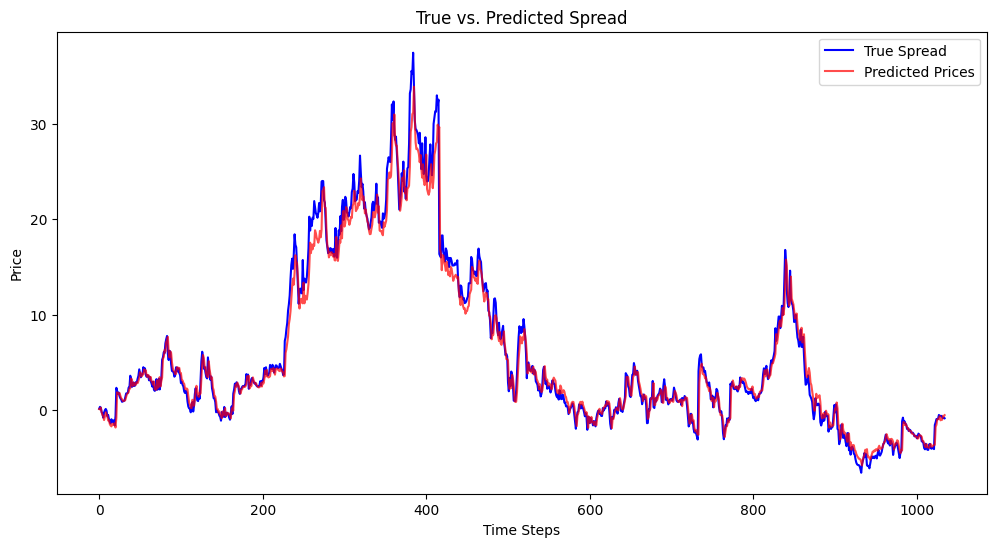

In [ ]:
# Example: Plot Predictions from the Last Window
plt.figure(figsize=(12, 6))
plt.plot(y_lstm[test_idx.min():test_idx.max()], label='True Spread', color='blue')
plt.plot(lstm_predictions[test_idx.min():test_idx.max()], label='Predicted Prices', color='red', alpha=0.7)
plt.title(f'True vs. Predicted Spread')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

predictions and actual spread of entire time series

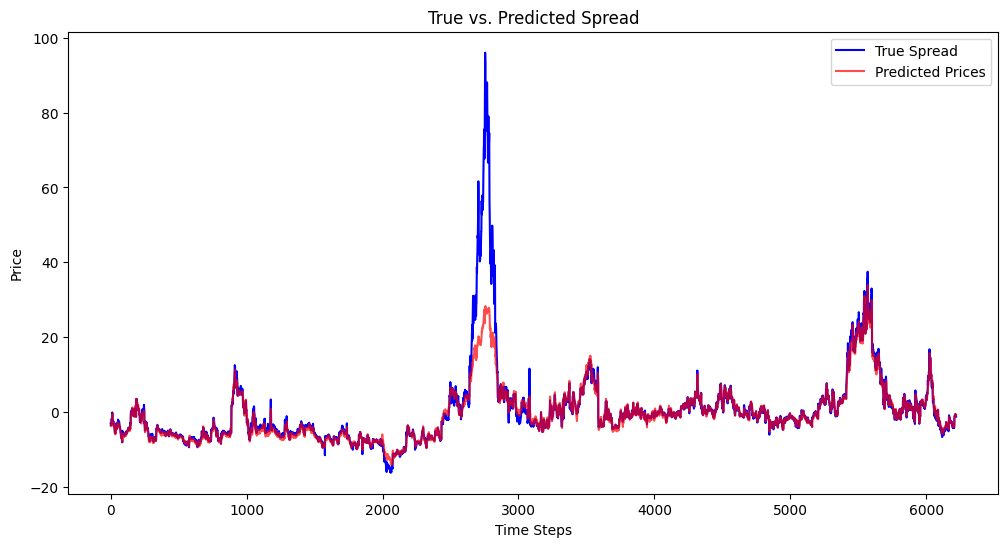

In [ ]:
# Example: Plot Predictions from the Last Window
plt.figure(figsize=(12, 6))
plt.plot(data['Future_DailyReturn'], label='True Spread', color='blue')
plt.plot(data['LSTM_Predictions'], label='Predicted Prices', color='red', alpha=0.7)
plt.title(f'True vs. Predicted Spread')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
model_output_backup = data.copy(deep=True)

In [ ]:
data = model_output_backup.copy(deep=True)

# TAKS 5 and 6: Evaluation
DISCLAIMER
- due to the stochastic optimalisation, and low amount of training periods in LSTM network training, results may vary.
- these results are illustration of an approach
- proper training of LSTM netwrok would require more layers, and more time to properly train and get consistent stable results with low amounts of variability in predictions
- this can be easily done by adjusting Network architecture, but for the purpose of this case study is not necessary
- fast training and easy approach has been selected instead to underline the proof of concept of presented model approach

## Predction to Actual R^2

                            OLS Regression Results                            
Dep. Variable:     Future_DailyReturn   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                 2.742e+04
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:55:43   Log-Likelihood:                -18463.
No. Observations:                6221   AIC:                         3.693e+04
Df Residuals:                    6219   BIC:                         3.694e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0932      0.060  

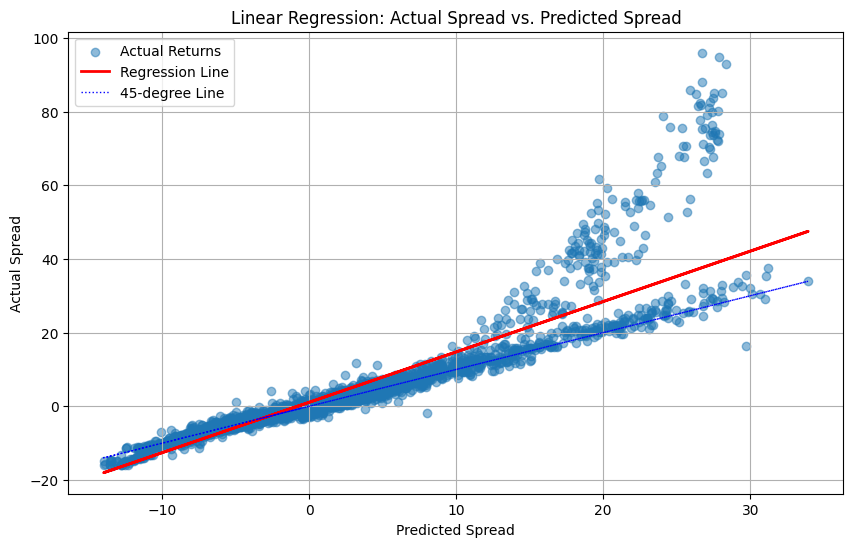

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Prepare the data for linear regression
X = data['LSTM_Predictions']
y = data['Future_DailyReturn']
X = sm.add_constant(X)  # Add a constant term (intercept)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

# Make predictions
y_pred = model.predict(X)

# Create the scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(data['LSTM_Predictions'], data['Future_DailyReturn'], alpha=0.5, label='Actual Returns')
plt.plot(data['LSTM_Predictions'], y_pred, color='red', linewidth=2, label='Regression Line')

# Plot the 45-degree line
plt.plot(data['LSTM_Predictions'], data['LSTM_Predictions'], color='blue', linestyle=':', linewidth=1, label='45-degree Line')


plt.xlabel('Predicted Spread')
plt.ylabel('Actual Spread')
plt.title('Linear Regression: Actual Spread vs. Predicted Spread')
plt.legend()
plt.grid(True)
plt.show()

## Maximum Drawdown

Assuming that
1. contracts are traded Contract1 - Contract5 for positive spreads. (Long Contract1, Short Contract5)
2. and Contract5 - Contract1 for negative spreads. (Short Contract1, Long Contract5)
3. Trades are opened and closed every day and follow model predictions.

Therefore we can work with spread in absolute term. Eliminating issues with negative values, since every day when spreads would turn negative, trade operations on Contract1 and Contract5 would switch.

Trading strategy is to open a trade every day, and close it the same day.

Aim is to measure the risk of the model predictions.

### Absolute maximal drawdown assuming NO contract switching
Allowing negative spreads

Data:

Running Peak:

Drawdown:

Maximum Drawdown (absolute): 39.799827575683594


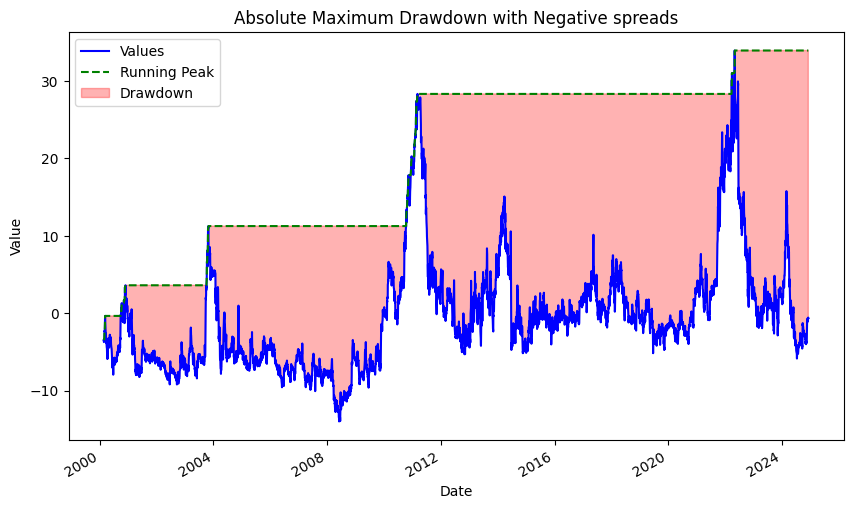

In [ ]:
# Extract values and calculate running peak and drawdown
values = (data['LSTM_Predictions'])
running_peak = values.cummax()
drawdown = running_peak - values
max_drawdown = drawdown.max()

# Display results
print("Data:")

print("\nRunning Peak:")

print("\nDrawdown:")

print(f"\nMaximum Drawdown (absolute): {max_drawdown}")

# Plot with datetime ticks
plt.figure(figsize=(10, 6))
plt.plot(data["Date"], values, label="Values", color="blue")
plt.plot(data["Date"], running_peak, label="Running Peak", color="green", linestyle="--")
plt.fill_between(data["Date"], running_peak, values, where=(running_peak > values), color="red", alpha=0.3, label="Drawdown")
plt.title("Absolute Maximum Drawdown with Negative spreads")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.gcf().autofmt_xdate()  # Auto-format x-axis for datetime
plt.show()

### Absolute maximal drawdown assuming contract switching
Allowing positive spreads only

Data:

Running Peak:

Drawdown:

Maximum Drawdown (absolute): 33.93838882446289


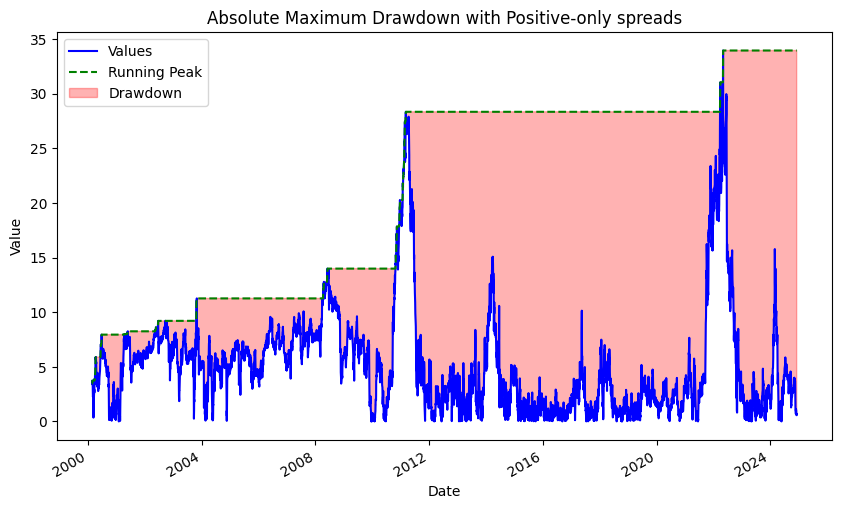

In [ ]:
# Extract values and calculate running peak and drawdown
values = abs(data['LSTM_Predictions'])
running_peak = values.cummax()
drawdown = running_peak - values
max_drawdown = drawdown.max()

# Display results
print("Data:")

print("\nRunning Peak:")

print("\nDrawdown:")

print(f"\nMaximum Drawdown (absolute): {max_drawdown}")

# Plot with datetime ticks
plt.figure(figsize=(10, 6))
plt.plot(data["Date"], values, label="Values", color="blue")
plt.plot(data["Date"], running_peak, label="Running Peak", color="green", linestyle="--")
plt.fill_between(data["Date"], running_peak, values, where=(running_peak > values), color="red", alpha=0.3, label="Drawdown")
plt.title("Absolute Maximum Drawdown with Positive-only spreads")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.gcf().autofmt_xdate()  # Auto-format x-axis for datetime
plt.show()

### Relative aximal drawdown assuming contract switching
Allowing positive spreads only
- With only positive spreads it is now possible to calculate % change, and calculate relative maximal drawdown


Cumulative Values:

Running Peak:

Drawdown (%):

Maximum Drawdown (%): 99.99


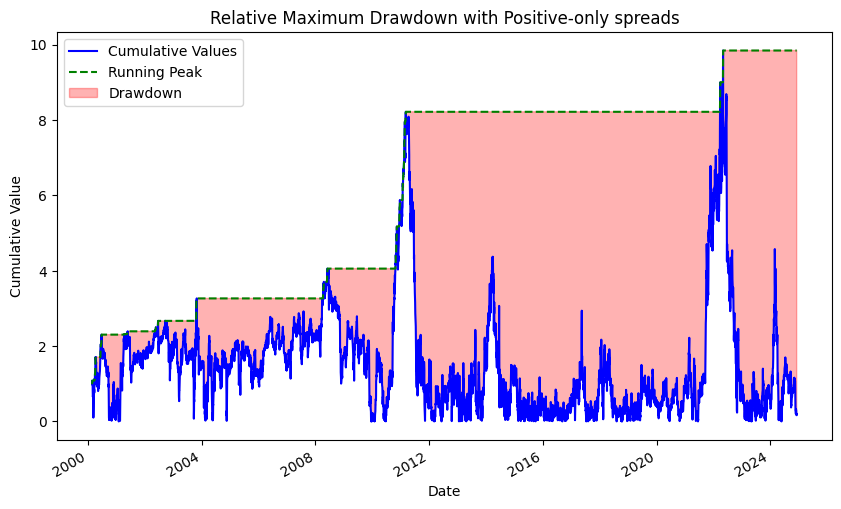

In [ ]:
# Calculate percentage change and cumulative product of absolute values
returns = abs(data["LSTM_Predictions"]).pct_change()
cumulative_values = (1 + returns).cumprod()

# Calculate running peak and relative drawdown
running_peak = cumulative_values.cummax()
drawdown = (running_peak - cumulative_values) / running_peak * 100
max_drawdown = drawdown.max()

# Display results
print("Cumulative Values:")

print("\nRunning Peak:")

print("\nDrawdown (%):")

print(f"\nMaximum Drawdown (%): {max_drawdown:.2f}")

# Plot with datetime ticks
plt.figure(figsize=(10, 6))
plt.plot(data["Date"], cumulative_values, label="Cumulative Values", color="blue")
plt.plot(data["Date"], running_peak, label="Running Peak", color="green", linestyle="--")
plt.fill_between(data["Date"], running_peak, cumulative_values, where=(running_peak > cumulative_values), color="red", alpha=0.3, label="Drawdown")
plt.title("Relative Maximum Drawdown with Positive-only spreads")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.legend()
plt.gcf().autofmt_xdate()  # Auto-format x-axis for datetime
plt.show()

## Sharpe ratio

### Sharpe ratio assuming positive-only values

In [ ]:
# Task 6: Calculate Annualized Sharpe Ratio
# --------------------------------------------
def calculate_sharpe_ratio(daily_returns):
    mean_daily_return = np.mean(daily_returns)
    std_daily_return = np.std(daily_returns)
    sharpe_ratio = (mean_daily_return / std_daily_return) * np.sqrt(252)
    return sharpe_ratio

values = abs(data['LSTM_Predictions']).pct_change()

sharpe_ratio = calculate_sharpe_ratio(values)
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")

Annualized Sharpe Ratio: 1.0609
